In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ranksums
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

Running on device: CUDA


In [4]:
from model import NeuralNetwork
from data_loader import *
from base import GradientFreeOptimization

In [5]:
train_loader = load_mnist_train(samples_per_class=100, seed=42, batch_size=64)
test_loader = load_mnist_test(batch_size=64)

Size of balanced training dataset: 1000
Size of balanced test dataset: 10000


In [6]:
gfo = GradientFreeOptimization(NeuralNetwork, test_loader, DEVICE)

In [7]:
max_iterations = 1000000
popsize = 100

In [29]:
def wtl_sign(devf_train_f1_last_runs, bdevf_train_f1_last_runs):
    s, r = ranksums(devf_train_f1_last_runs, bdevf_train_f1_last_runs)

    sign = "="
    if r < 0.05:
        if s < 0:
            sign = "+"
        else:
            sign = "-"
            
    return sign

BDE with B=10 vs DE, **order1** and **vectorized random** $F = [0.1, 1.0]$

In [23]:
table_df = pd.DataFrame({"Data": ["Train", "Test"]})

In [44]:
# DE, rand1bin classic F=0.5
runs=7
devf_test_f1_runs, devf_train_f1_runs, devf_train_f1_last_runs, devf_curr_FE_runs = [], [], [], []
for nrun in range(runs):
    saved_output = np.load(f"output/output-de-classic-10runs/ann_de_np100_rand1bin_maxFE600000_mnist_training_history_{nrun}.npz")
    params = saved_output['best_solution']
    devf_test_f1 = gfo.fitness_func(params) * -100
    devf_test_f1_runs.append(devf_test_f1)
    devf_train_f1 = saved_output['fitness_history']
    devf_train_f1_runs.append(devf_train_f1)
    devf_train_f1_last = devf_train_f1[-1] * -100
    devf_train_f1_last_runs.append(devf_train_f1_last)
    devf_curr_FE = len(saved_output['fitness_history'])*popsize
    devf_curr_FE_runs.append(devf_curr_FE)
    
table_df["DE classic"] = [f"{np.mean(devf_train_f1_last_runs, axis=0):.2f} ({np.std(devf_train_f1_last_runs, axis=0):.2f})",
                        f"{np.mean(devf_test_f1_runs, axis=0):.2f} ({np.std(devf_test_f1_runs, axis=0):.2f})"]

In [45]:
# BLOCK DE, BS=10 vectorized rand1bin
runs=7
block_size=10
bdevf_test_f1_runs, bdevf_train_f1_runs, bdevf_train_f1_last_runs, bdevf_curr_FE_runs = [], [], [], []
for nrun in range(runs):
    saved_output = np.load(f"output/bde-b10-order1-vector-10runs/ann_bde_np100_order1bin_b10_maxFE600000_mnist_training_history_{nrun}.npz")
    params = saved_output['best_solution']
    bdevf_test_f1 = gfo.fitness_func(params) * -100
    bdevf_test_f1_runs.append(bdevf_test_f1)
    bdevf_train_f1 = saved_output['fitness_history']
    bdevf_train_f1_runs.append(bdevf_train_f1)
    bdevf_train_f1_last = bdevf_train_f1[-1] * -100
    bdevf_train_f1_last_runs.append(bdevf_train_f1_last)
    bdevf_curr_FE = len(saved_output['fitness_history'])*popsize
    bdevf_curr_FE_runs.append(bdevf_curr_FE)
            
sign_train = wtl_sign(devf_train_f1_last_runs, bdevf_train_f1_last_runs)
sign_test = wtl_sign(devf_test_f1_runs, bdevf_test_f1_runs)
    
table_df["BDE vectorized F=[0.1, 1.0] BS=10"] = [f"{np.mean(bdevf_train_f1_last_runs, axis=0):.2f} ({np.std(bdevf_train_f1_last_runs, axis=0):.2f}) {sign_train}",
                                                f"{np.mean(bdevf_test_f1_runs, axis=0):.2f} ({np.std(bdevf_test_f1_runs, axis=0):.2f}) {sign_test}"]

In [46]:
# BLOCK DE, BS=100 vectorized rand1bin
runs=7
block_size=100
bdevf100_test_f1_runs, bdevf100_train_f1_runs, bdevf100_train_f1_last_runs, bdevf100_curr_FE_runs = [], [], [], []
for nrun in range(runs):
    saved_output = np.load(f"output/bde-b100-order1-vector-10runs/ann_bde_np100_order1bin_b100_maxFE600000_mnist_training_history_{nrun}.npz")
    params = saved_output['best_solution']
    bdevf_test_f1 = gfo.fitness_func(params) * -100
    bdevf100_test_f1_runs.append(bdevf_test_f1)
    bdevf_train_f1 = saved_output['fitness_history']
    bdevf100_train_f1_runs.append(bdevf_train_f1)
    bdevf_train_f1_last = bdevf_train_f1[-1] * -100
    bdevf100_train_f1_last_runs.append(bdevf_train_f1_last)
    bdevf_curr_FE = len(saved_output['fitness_history'])*popsize
    bdevf100_curr_FE_runs.append(bdevf_curr_FE)
    
sign_train = wtl_sign(devf_train_f1_last_runs, bdevf100_train_f1_last_runs)
sign_test = wtl_sign(devf_test_f1_runs, bdevf100_test_f1_runs)
    
table_df["BDE vectorized F=[0.1, 1.0] BS=100"] = [f"{np.mean(bdevf100_train_f1_last_runs, axis=0):.2f} ({np.std(bdevf100_train_f1_last_runs, axis=0):.2f}) {sign_train}",
                                                f"{np.mean(bdevf100_test_f1_runs, axis=0):.2f} ({np.std(bdevf100_test_f1_runs, axis=0):.2f}) {sign_test}"]

In [47]:
table_df.head()

,Data,DE classic,"BDE vectorized F=[0.1, 1.0] BS=10","BDE vectorized F=[0.1, 1.0] BS=100"
0,Train,76.37 (4.23),73.07 (6.28) =,70.28 (4.07) -
1,Test,66.09 (2.98),64.46 (6.10) =,61.29 (3.43) -


In [42]:
table_df.to_csv(f"output/ann_bde_b10_b100_order1_vectorizedF_01_10_de_classic_maxFE600000_mnist_comparison_10runs.csv", index=False)

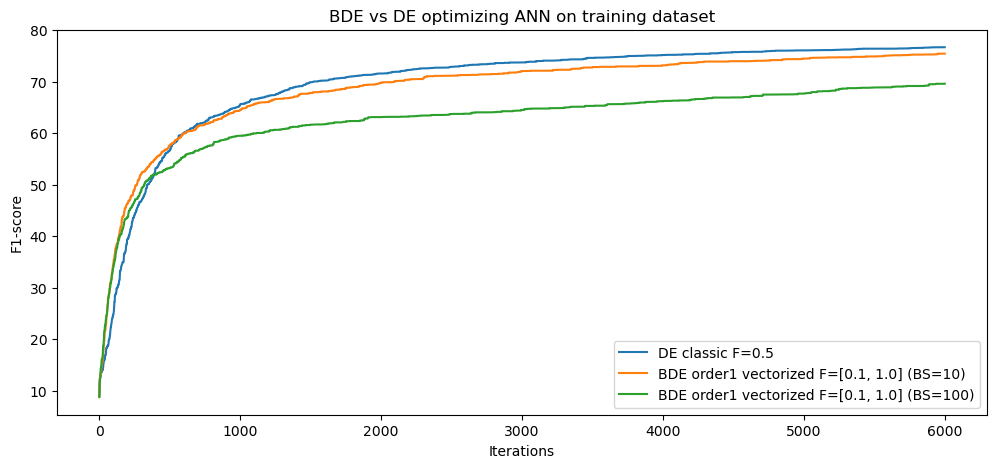

In [43]:
    max_iter=-1
    
    plt.figure(figsize=(12, 5))
    #plt.plot(de_train_f1[:max_iter] * -100, label='DE F=0.5')
    #plt.plot(bde_train_f1[:max_iter] * -100, label='BDE F=[0.1, 1.0] (BS=10)')
    #plt.plot(devf_r1_train_f1[:max_iter] * -100, label='DE vectorized F=[0.1, 1.0] run1')
    #plt.plot(devf_r2_train_f1[:max_iter] * -100, label='DE vectorized F=[0.1, 1.0] run2')
    plt.plot(np.mean(devf_train_f1_runs[:6], 0)[:max_iter] * -100, label='DE classic F=0.5')
    plt.plot(np.mean(bdevf_train_f1_runs[:], 0)[:max_iter] * -100, label='BDE order1 vectorized F=[0.1, 1.0] (BS=10)')
    plt.plot(np.mean(bdevf100_train_f1_runs[:], 0)[:max_iter] * -100, label='BDE order1 vectorized F=[0.1, 1.0] (BS=100)')
    plt.xlabel('Iterations')
    plt.ylabel('F1-score')
    plt.legend()
    plt.title("BDE vs DE optimizing ANN on training dataset")
    plt.savefig(f"output/ann_bde_b10_b100_order1_vectorizedF_01_10_de_classic_maxFE600000_mnist_comparison_10runs.png")
    plt.show()